# 1. Using the trained model, find semantically similar words for other input words. Can you improve the results by tuning hyperparameters?

In [2]:
import time
import collections
import math
import os
import random
import torch
import warnings
import sys
import pandas as pd
import torch
import torch.nn as nn
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")

#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')
#@save
class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""
    def __init__(self, sampling_weights,k=10000):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0
        self.k = k

    def draw(self):
        if self.i == len(self.candidates):
            # Cache `k` random sampling results
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=self.k)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]
    
#@save
def subsample(sentences, vocab,flag=True):
    """Subsample high-frequency words."""
    # Exclude unknown tokens ('<unk>')
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = collections.Counter([
        token for line in sentences for token in line])
    num_tokens = sum(counter.values())

    # Return True if `token` is kept during subsampling
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))
    if flag:
        return ([[token for token in line if keep(token)] for line in sentences],
            counter)
    return (sentences,counter)

#@save
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        # To form a "center word--context word" pair, each sentence needs to
        # have at least 2 words
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the center word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

#@save
def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    data_dir = d2l.download_extract('ptb')
    # Read the training set
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

#@save
def get_negatives(all_contexts, vocab, counter, K, k=10000):
    """Return noise words in negative sampling."""
    # Sampling weights for words with indices 1, 2, ... (index 0 is the
    # excluded unknown token) in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights,k)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

#@save
def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words, flag=True, k=10000):
    """Download the PTB dataset and then load it into memory."""
    # num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab, flag)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words, k=k)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=batchify)
    return data_iter, vocab

def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

def train(net, data_iter, lr, num_epochs, device='cpu'):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    loss = SigmoidBCELoss()
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')
    return metric[0] / metric[1]

def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

loss 0.410, 55995.3 tokens/sec on cpu


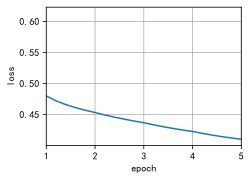

In [8]:
data_iter, vocab = load_data_ptb(512, 5, 5)
lr, num_epochs = 0.002, 5
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))
train(net, data_iter, lr, num_epochs)

loss 0.384, 36166.7 tokens/sec on cpu


0.3843912484866804

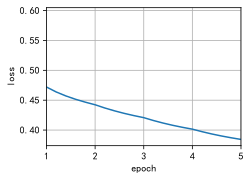

In [11]:
lr, num_epochs = 0.002, 5
embed_size = 200
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))
train(net, data_iter, lr, num_epochs)

In [14]:
get_similar_tokens('intel', 3, net[0])

cosine sim=0.551: workstations
cosine sim=0.537: microprocessor
cosine sim=0.525: compaq


# 2. When a training corpus is huge, we often sample context words and noise words for the center words in the current minibatch when updating model parameters. In other words, the same center word may have different context words or noise words in different training epochs. What are the benefits of this method? Try to implement this training method.

In [54]:
import random

def random_line(afile):
    line = next(afile)
    for num, aline in enumerate(afile, 2):
        temp = random.randrange(num)
        print(temp,num)
        if temp:
            continue
        line = aline
    return line

data_dir = d2l.download_extract('ptb')
    # Read the training set
with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
    a = random_line(f)
    print(a)

1 2
1 3
1 4
1 5
3 6
3 7
5 8
8 9
1 10
6 11
11 12
2 13
4 14
5 15
14 16
4 17
14 18
7 19
9 20
17 21
12 22
21 23
0 24
9 25
10 26
16 27
16 28
21 29
21 30
16 31
5 32
19 33
24 34
32 35
5 36
35 37
13 38
10 39
7 40
22 41
38 42
12 43
11 44
18 45
9 46
23 47
6 48
45 49
0 50
20 51
35 52
50 53
35 54
39 55
31 56
21 57
56 58
9 59
35 60
39 61
25 62
8 63
53 64
46 65
64 66
18 67
29 68
50 69
46 70
52 71
5 72
60 73
46 74
52 75
74 76
70 77
1 78
45 79
57 80
55 81
32 82
80 83
19 84
76 85
64 86
32 87
19 88
50 89
68 90
40 91
52 92
49 93
5 94
35 95
48 96
40 97
30 98
4 99
83 100
30 101
98 102
46 103
60 104
62 105
32 106
5 107
10 108
45 109
13 110
91 111
45 112
90 113
41 114
17 115
103 116
32 117
92 118
77 119
16 120
59 121
28 122
56 123
60 124
101 125
15 126
11 127
57 128
35 129
48 130
13 131
79 132
55 133
115 134
134 135
3 136
115 137
116 138
28 139
36 140
87 141
88 142
25 143
34 144
90 145
140 146
11 147
126 148
98 149
52 150
18 151
58 152
63 153
74 154
20 155
125 156
113 157
138 158
98 159
66 160
158 161
53 162

In [44]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        self.token_freqs = collections.Counter(tokens)
        # counter = collections.Counter(tokens)
        # self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
        #                           reverse=True)
        # The list of unique tokens
        filter_tokens = list(set(['<unk>'] + reserved_tokens + [
            token for token in self.token_freqs if self.token_freqs[token] >= min_freq]))
        self.idx_to_token = {}
        self.token_to_idx = {}
        for idx, token in enumerate(filter_tokens):
            self.idx_to_token[idx]=token
            self.token_to_idx[token]=idx
        self.cur_id = len(self.idx_to_token)

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]
    
    def update(self, tokens):
        # 统计tokens中每个词的出现次数，并更新到原有的词频字典中
        counter = collections.Counter(tokens)
        self.token_freqs.update(counter)
        # 遍历新出现的词，给每个词分配一个id，并更新两个映射字典
        for token in counter:
            if token not in self.token_to_idx:
                self.token_to_idx[token] = self.cur_id
                self.idx_to_token[self.cur_id] = token
                self.cur_id += 1
    
    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [42]:
a = Vocab(tokens=[2,6,9,2,1,9,6])
a.token_freqs

Counter({2: 2, 6: 2, 9: 2, 1: 1})

In [43]:
a.update([1,3])
a.token_freqs

Counter({2: 2, 6: 2, 9: 2, 1: 2, 3: 1})

In [30]:
for token in token_freq:
    print(token,token_freq[token])

2 2
6 2
9 2
1 2
3 1


In [24]:
tokens = [2,6,9,2,1,9,6]
counter = collections.Counter(tokens)
# 将字典按照词频降序排序，返回一个列表
# token_freq = sorted(counter.items(), key=lambda x: x[1], reverse=True)
token_freq = counter

In [25]:
counter = collections.Counter([1,3])
token_freq.update(counter)

In [3]:
def get_negatives(all_contexts, vocab, counter, K, k=10000):
    """Return noise words in negative sampling."""
    # Sampling weights for words with indices 1, 2, ... (index 0 is the
    # excluded unknown token) in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights,k)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        # To form a "center word--context word" pair, each sentence needs to
        # have at least 2 words
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = max_window_size
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the center word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    K = 5
    max_len = max(len(c)*(K+1) for _, c in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context in data:
        cur_len = len(context)
        centers += [center]
        contexts_negatives += [context + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

def load_data_ptb(batch_size, max_window_size, num_noise_words, flag=True, k=10000):
    """Download the PTB dataset and then load it into memory."""
    # num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab,flag)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    
    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts):
            assert len(centers) == len(contexts)
            self.centers = centers
            self.contexts = contexts

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                            collate_fn=batchify)
    return data_iter, vocab

def train(net, data_iter, lr, num_epochs, device='cpu'):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    loss = SigmoidBCELoss()
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')
    return metric[0] / metric[1]

In [4]:
data_iter, vocab = load_data_ptb(512, 5, 5)

In [12]:
names = ['centers', 'contexts_negatives', 'masks', 'labels']
for batch in data_iter:
    a = batch[-1]
    # a = batch[-1].sum(axis=1)
    # for name, data in zip(names, batch):
    #     print(name, 'shape:', data.shape)
    #     print(data[:1].sum(axis=1),data[:1])
    break

In [20]:
a.shape

torch.Size([512, 60])

In [17]:
a

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [18]:
b = torch.round(torch.rand(a.shape))
b

tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 1., 1., 0.],
        [1., 0., 1.,  ..., 1., 0., 1.],
        ...,
        [1., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 1., 1., 1.],
        [0., 1., 0.,  ..., 1., 0., 1.]])

In [19]:
c = a*b
c

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

In [8]:
d = torch.zeros(batch[-1].shape)
for i in range(len(c)):
    # print(int(c[i]))
    d[i][:int(c[i])]=1
d

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])